In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import keras
import keras.optimizers as optimizers
from keras import layers, callbacks
from keras import regularizers
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
import pyreadr
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import random

### PCA Class

In [108]:
class PCAProcess:
    def __init__(self):
        pass
    
    def flatten(self, data):
        self.samples, self.timestamps, self.features = data.shape[0], data.shape[1], data.shape[2]
        return data.reshape(self.samples * self.timestamps, self.features)
    
    def reshape(self, data):
        return data.reshape(self.samples, self.timestamps, self.features)
    
    def normalize(self, data):        
        scaler = MinMaxScaler()
        a = self.flatten(data)
        b = scaler.fit_transform(a)
        data = self.reshape(b)
        return data

    def fit_pca(self, data, n_components):
        self.n_components = n_components
        self.pca = PCA(n_components=n_components)

        data = self.flatten(data)
        self.pca.fit(data)
        data_pca = self.pca.transform(data)
        data_rec = self.pca.inverse_transform(data_pca)
        data_rec = self.reshape(data_rec)
        return data_rec
    
    def evaluate(self, n_data, n_data_rec, f_data):
        f_data = self.flatten(f_data)
        f_data_pca = self.pca.transform(f_data)
        self.f_data_rec = self.pca.inverse_transform(f_data_pca)
        self.f_data_rec = self.reshape(self.f_data_rec)
        f_data = self.reshape(f_data)
        
        self.threshold = np.max(np.mean(np.abs(n_data - n_data_rec), axis=1))
        f_error = np.mean(np.abs(f_data - self.f_data_rec), axis=1)
        
        result = []
        for i in range(len(f_error)):
            anomalies = f_error[i,] > self.threshold
            if np.sum(anomalies >= 1):
                result.append(1)
            else:
                result.append(0)
        return np.sum(np.array(result))
    
    def get_f_rec(self):
        return self.f_data_rec
    
    def plot(self, n_data, n_data_rec, f_data, f_data_rec, sample, feature):
        plt.figure(figsize=(12, 12))
        plt.subplot(211)
        plt.title(f"Normal Data Mean Absolute Error: {mae(n_data[sample][:, feature], n_data_rec[sample][:, feature])}")
        plt.plot(n_data[sample][:, feature])
        plt.plot(n_data_rec[sample][:, feature])
        plt.subplot(212)
        plt.title(f"Faulty Data Mean Absolute Error: {mae(f_data[sample][:, feature], f_data_rec[sample][:, feature])}")
        plt.plot(f_data[sample][:, feature])
        plt.plot(f_data_rec[sample][:, feature])
        plt.show()

#### Normal Data

In [2]:
class DataCreation:
    def __init__(self):
        pass
    
    def create_feature(self, function, mean, variance, co_ef, intercept):
        x = co_ef * function(np.linspace(0, 50*np.pi, 1000)) + intercept
        x = x + np.random.normal(mean, variance, 1000)
        return x
    
    def create_samples(self, num_samples, features, seed):
        self.num_samples = num_samples
        self.features = features
        self.X = []
        
        for i in range(num_samples):
            d = {}
            random.seed(seed)            
            for j in range(features):
                
                co_ef = random.randint(1, 10)
                intercept = random.uniform(0, 500)
                mean = 0
                variance = random.uniform(0.1, 2)
                function = random.choice([np.sin, np.cos])
                
                d[f'x_{j}'] = self.create_feature(function, mean, variance, co_ef, intercept)
            training = pd.DataFrame(d)
            self.X.append(training)
        self.X = np.array(self.X)
        return self.X
    
    def plot_feature(self, data, sample, feature):
        plt.figure(figsize=(12, 6))
        plt.plot(data[sample][:,feature])
        plt.show()
        pass

In [98]:
n_data = DataCreation()
n_train_X = n_data.create_samples(1000, 50, 2)
n_train_X.shape

(1000, 1000, 50)

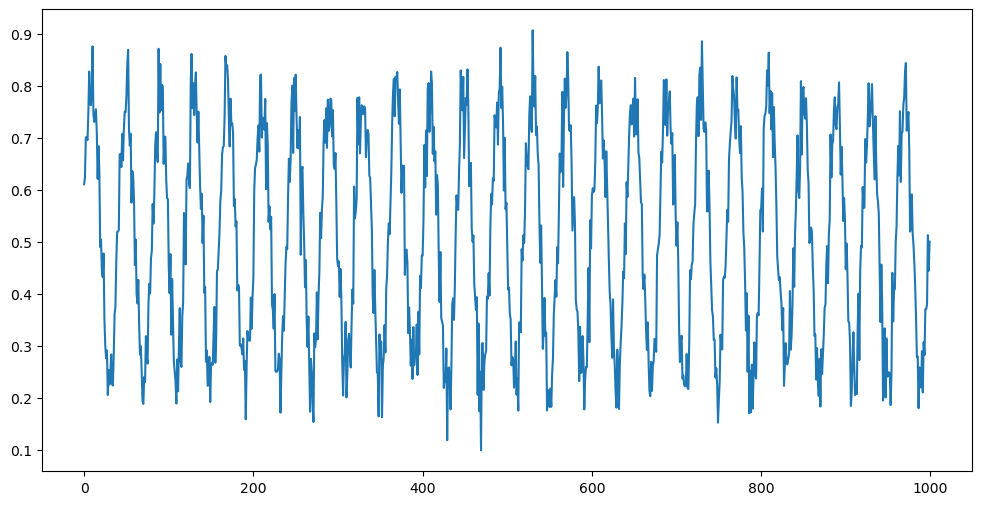

In [104]:
n_data.plot_feature(n_train_X, 0, 49)

#### Faulty Data: Point Anomaly

In [94]:
f_data = DataCreation()
f_train_X = f_data.create_samples(1000, 50, 2)
f_train_X.shape

(1000, 1000, 50)

In [95]:
random.seed(1000)
for i in range(1000):
    rand_feature = random.choice([i for i in range(50)])
    rand_timestamp = random.choice([i for i in range(1000)])
    f_train_X[i][rand_timestamp, rand_feature] = np.mean(f_train_X[i][:,rand_feature]) + 3*np.std(f_train_X[i][:,rand_feature])

In [96]:
random.seed(1000)
print(random.choice([i for i in range(50)]), random.choice([i for i in range(1000)]))

49 439


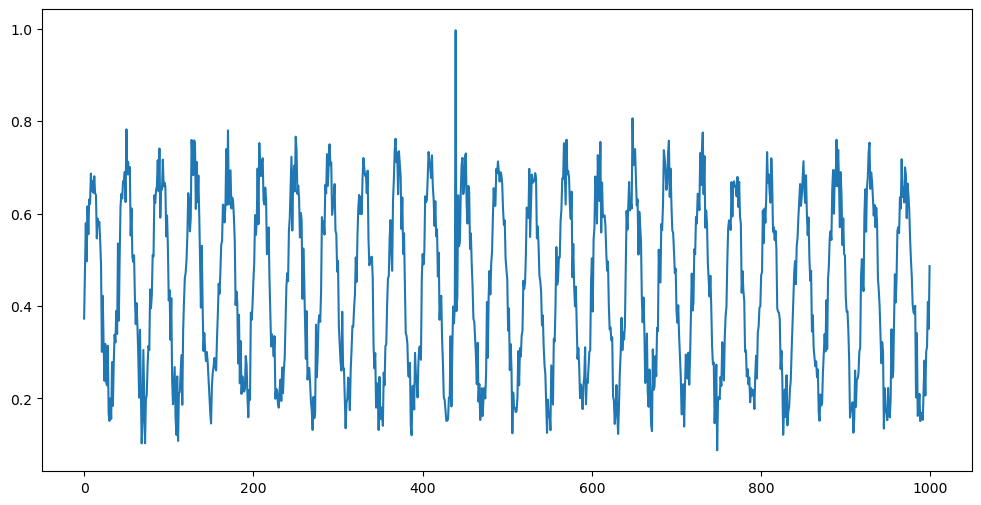

In [103]:
f_data.plot_feature(f_train_X, 0, 49)

Threshold Value: 0.07150287882349367
Total Anomalies out of 1000: 1000


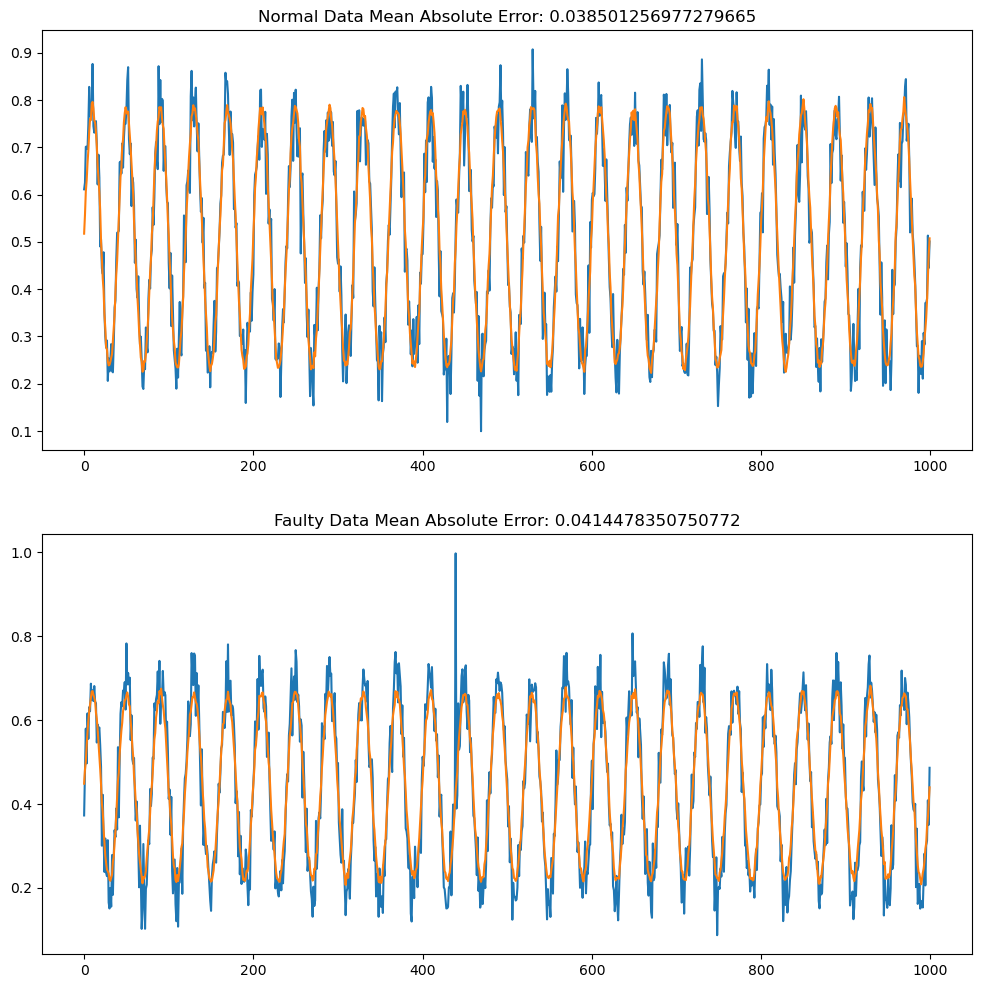

In [109]:
pca = PCAProcess()
n_train_X, f_train_X = pca.normalize(n_train_X), pca.normalize(f_train_X)
n_train_rec = pca.fit_pca(n_train_X, 5)
anomalies = pca.evaluate(n_train_X, n_train_rec, f_train_X)
f_train_rec = pca.get_f_rec()
print(f"Threshold Value: {pca.threshold}")
print(f"Total Anomalies out of {pca.samples}: {anomalies}")
pca.plot(n_train_X, n_train_rec, f_train_X, f_train_rec, 0, 49)

#### Faulty Data: Collective Anomalies

In [110]:
f_data = DataCreation()
f_train_X = f_data.create_samples(1000, 50, 2)
f_train_X.shape

(1000, 1000, 50)

In [111]:
random.seed(1001)
for i in range(1000):
    rand_feature = random.choice([i for i in range(50)])
    rand_timestamp = random.choice([i for i in range(1000)])
    f_train_X[i][rand_timestamp:rand_timestamp+20, rand_feature] = f_train_X[i][rand_timestamp, rand_feature]

In [125]:
#random.seed(1001)
print(random.choice([i for i in range(50)]), random.choice([i for i in range(1000)]))

24 804


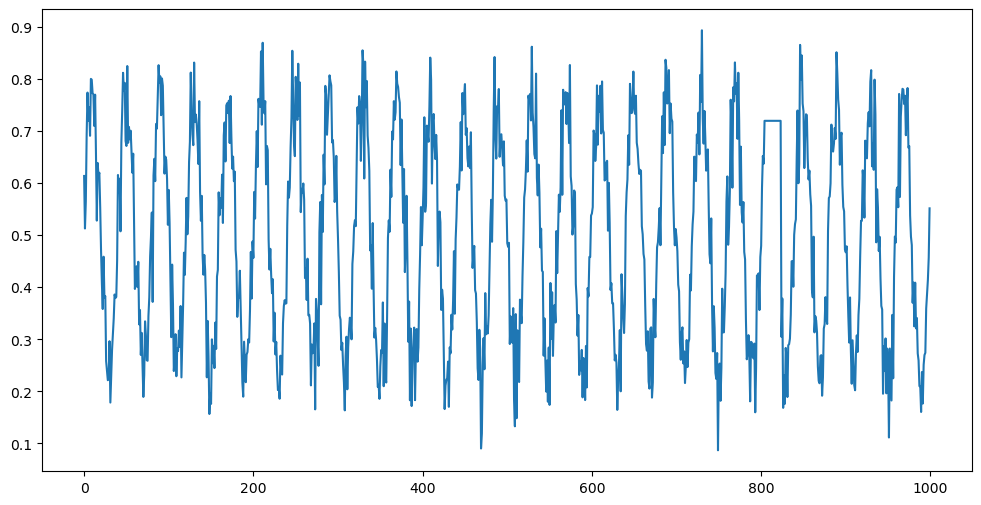

In [126]:
f_data.plot_feature(f_train_X, 3, 24)

Threshold Value: 0.07130184898965376
Total Anomalies out of 1000: 2


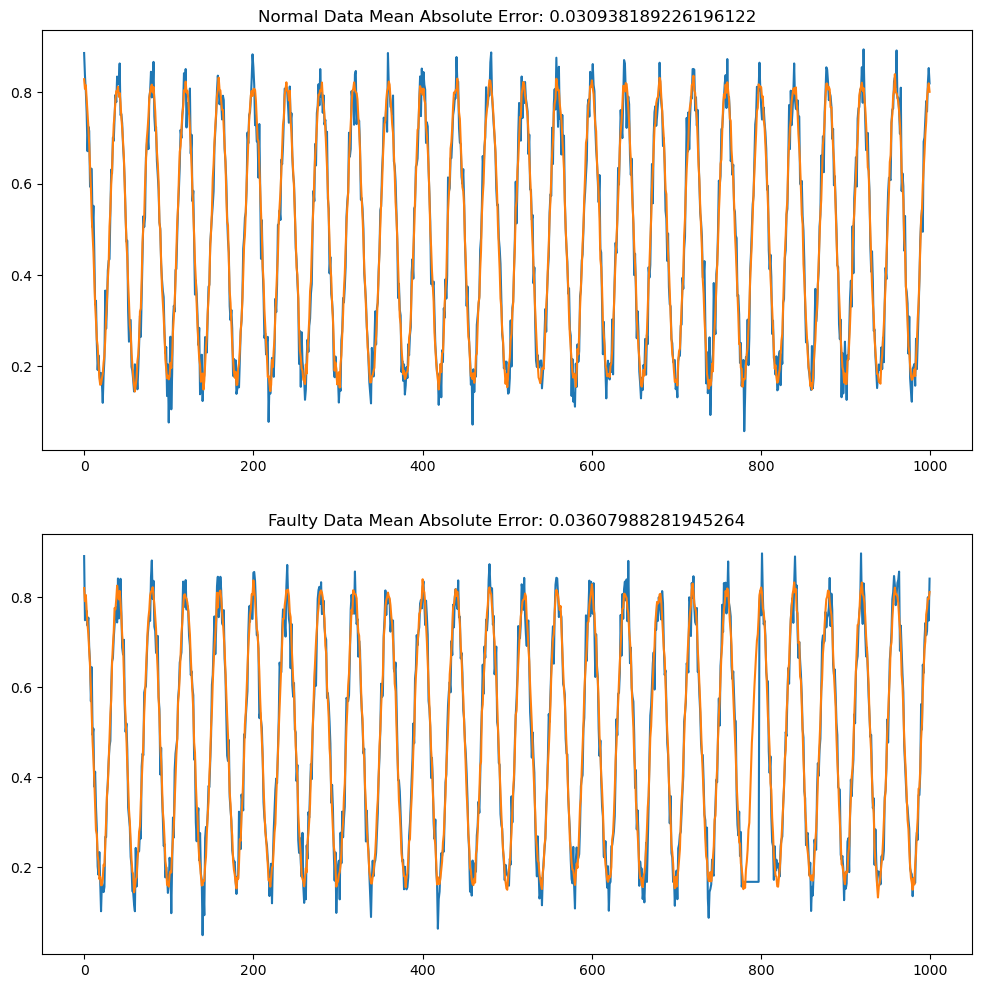

In [115]:
pca = PCAProcess()
n_train_X, f_train_X = pca.normalize(n_train_X), pca.normalize(f_train_X)
n_train_rec = pca.fit_pca(n_train_X, 5)
anomalies = pca.evaluate(n_train_X, n_train_rec, f_train_X)
f_train_rec = pca.get_f_rec()
print(f"Threshold Value: {pca.threshold}")
print(f"Total Anomalies out of {pca.samples}: {anomalies}")
pca.plot(n_train_X, n_train_rec, f_train_X, f_train_rec, 0, 3)

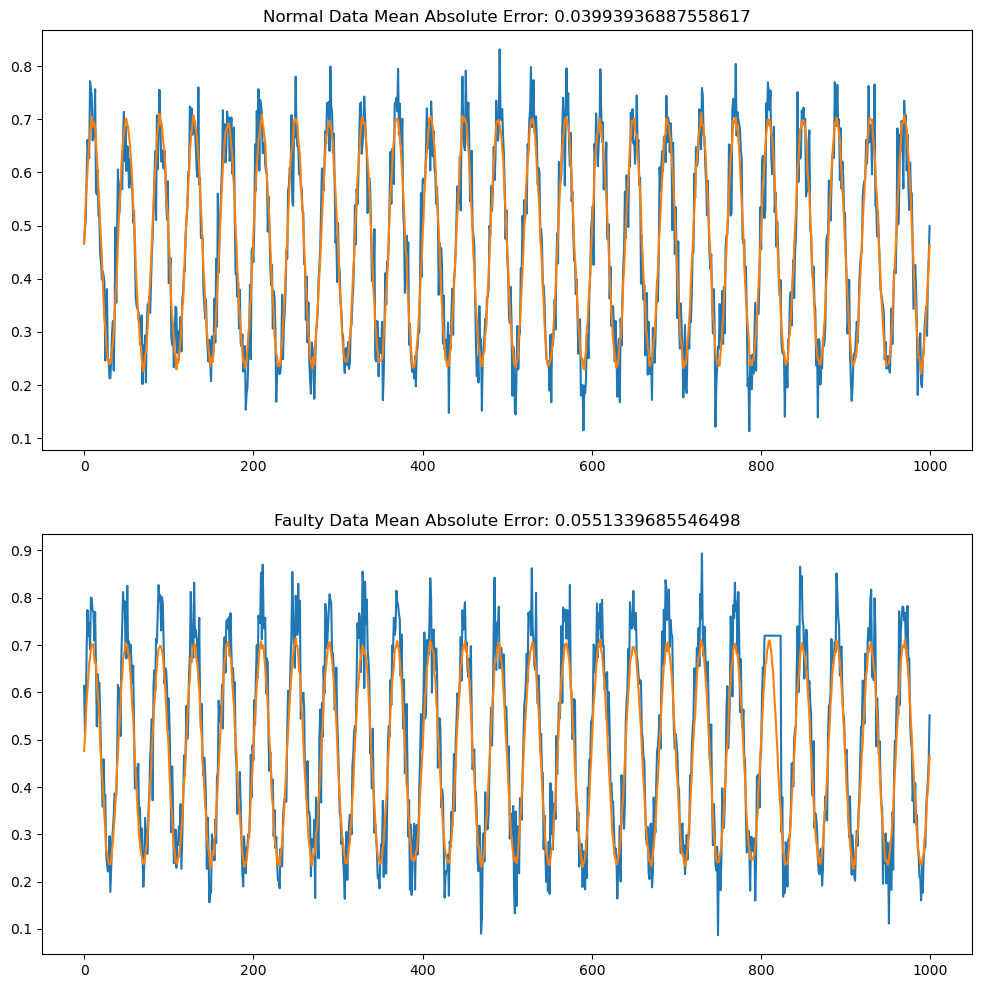

In [127]:
pca.plot(n_train_X, n_train_rec, f_train_X, f_train_rec, 3, 24)

#### Faulty Data: Contextual Anomaly

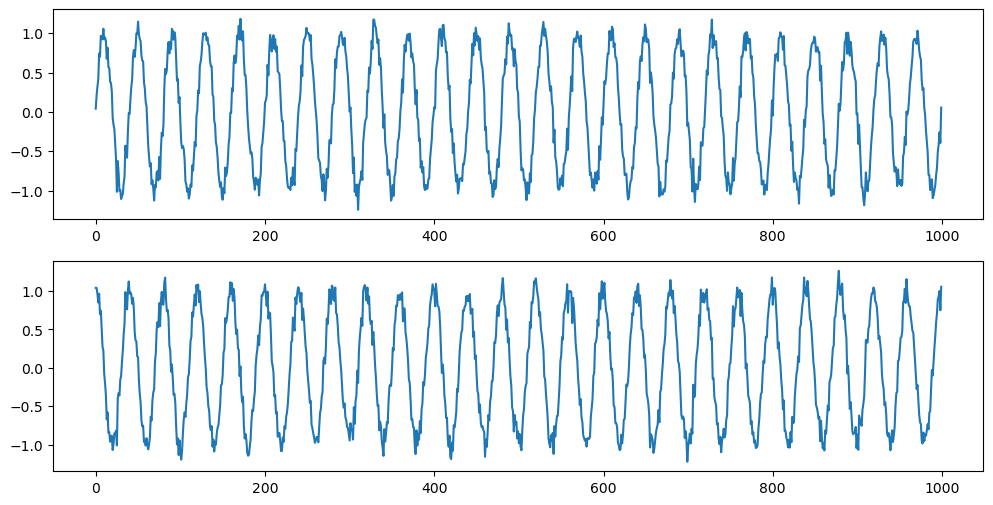

In [131]:
plt.figure(figsize=(12, 6))
a = np.sin(np.linspace(0, 50*np.pi, 1000))
b = np.random.normal(0, 0.1, 1000)
c = np.cos(np.linspace(0, 50*np.pi, 1000))
x_1 = a + b
x_2 = c + b
plt.subplot(211)
plt.plot(x_1)
plt.subplot(212)
plt.plot(x_2)
plt.show()

#### PCA